
# xView2 Challenge Dataset 
## Exploratory Data Analysis

### About

This notebook reads the processed dataset of labels and conducts an EDA on the labels and images. A separate map link is made available for exploring the data interactively. 

### Data
| **Name** | **Type** | **Location Type** | **Description** | **Location** | 
| --- | --- | --- | --- | --- | 
| `full_challenge_data` | `input` | `S3` | Read the transformed label data from S3 after processing through ingestion | `s3://BUCKET/datasets/xview2/processed/full_challenge_data.parquet` | 
| `buildings` | `output` | `S3` | Building-level data  | `s3://BUCKET/datasets/xview2/processed/buildings.parquet` | 
| `images` | `output` | `S3` | Image-level data  | `s3://BUCKET/datasets/xview2/processed/images.parquet` | 
| `image_pairs` | `output` | `S3` | Image-Pairs data (half of images)  | `s3://BUCKET/datasets/xview2/processed/image_pairs.parquet` | 

### Compute Resources

32 GB RAM, 4 cores

### Last Updated
`Feb 13, 2024`

In [0]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from smart_open import open
from PIL import Image
from io import BytesIO
import inflection
from typing import Literal

from src.utils.config import S3_BUCKET

In [0]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_rows", 10_000_000)

sns.set_theme()


### Read Preprocessed Label Data

The dataset contains all of `train`, `test` and `holdout` records in a single file. It also contains image names of the respective records, which has to be prefixed with the location either locally or S3, so that they can be read by the notebook.

Example: 
* S3: `IMG_01.png` -> `s3://BUCKET/datasets/xview2/challenge/train/images/IMG_01.png` or;
* Local: `IMG_01.png` -> `./train/images/IMG_01.png`

> The dataset is at a per-train/test, per-building level. 


#### Primary Fields

* `id` refers to an individual image - unique to a pre-image and a post-image as having separate IDs
* `image_id` (think of it as a `pair_id`) column refers to all data related to a single image - both pre-and-post image will have the same `image_id`
* `building_id` column refers to the the data for a building. One `id` or `image_id` can have many `building_id`
* `*_polygon` columns refer to the vertices of the polygon / shape in `wkt` format of the building when plotted on: 
  * `map_polygon`: a world map. They're set to `WGS:84` projection
  * `image_polygon`: the satellite image of resolution `width` x `height`

In [0]:
DATA_URL: str = (
    f"s3://{S3_BUCKET}/datasets/xview2/processed/full_challenge_data.parquet"
)
print(DATA_URL)

s3://alivio/datasets/xview2/processed/full_challenge_data.parquet


In [0]:
df: pd.DataFrame = pd.read_parquet(DATA_URL)

print(df.shape)
df.head()

(545816, 27)


,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,catalog_id,original_width,original_height,width,height,id,img_name,map_polygon,building_id,image_polygon,feature_type,damage,dataset,image_id,is_pre_image,is_post_image
0,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83554484998086 14.43845885230631...,88703461-a33d-4327-9244-a0d4e2242ede,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
1,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83658244456636 14.43748886352666...,e168e405-3479-44ee-849a-7af2ed32dee1,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test,guatemala-volcano_00000003,False,True
2,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83487803042956 14.43776515972186...,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
3,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,flooding,10500100123A5000,1024,1024,1024,1024,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05237408501472 33.58644838741007...,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test,hurricane-florence_00000005,False,True
4,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,flooding,10500100123A5000,1024,1024,1024,1024,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05057793741786 33.58642007435035...,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test,hurricane-florence_00000005,False,True


We can see that `dataset`, `id` and `building_id` together make up all unique rows of the data. We also make some other assertions on the integrity of the dataset

In [0]:
assert (
    df.drop_duplicates(subset=["dataset", "id", "building_id"]).shape == df.shape
), "Data contains duplicates"

assert (
    df.groupby(["image_id"])["dataset"].nunique().max() == 1
), "Same image appears in two or more of train/test/validation sets"

assert (
    df.groupby(["image_id"])["id"].nunique().max() == 2
), "One or more images has more than a pair of pre-and-post images"

assert (
    df.groupby(["building_id"])["dataset"].nunique().max() == 1
), "Same building appears in two or more of train/test/validation sets"

### Create Reshaped Datasets

* We create a `disaster_sub_type` column to distinguish disasters with more granularity
* We also need to create different levels of aggregations to analyze the data. Our base `df` is at a building-level, which means images and image-pairs are duplicated (`id`, and `image_id`). They are defined as follows:
  * `img_df` (`images`): Each row represents a distinct image. It also contains a building and damage count present within that image
  * `pair_df` (`image_pairs`): Each row represents a pair of pre-and-post images (united by `image_id`). This will be half the size of `img_df`
  * `building_df` (`buildings`): A copy of `df` with fewer columns. 

These different dataframes allow us to normalize the data. They can be joined back based on common columns, or one can just reference `df`.
The reshaped / normalized dataframes ease our analysis and also can be saved for future use.

In [0]:
disaster_sub_type_map: dict[str, str] = {
    "palu-tsunami": "tsunami",
    "mexico-earthquake": "earthquake",
    "hurricane-harvey": "hurricane",
    "hurricane-michael": "hurricane",
    "hurricane-matthew": "hurricane",
    "santa-rosa-wildfire": "wildfire",
    "socal-fire": "wildfire",
    "midwest-flooding": "flood",
    "hurricane-florence": "hurricane",
    "guatemala-volcano": "volcano",
}

df["disaster_sub_type"] = df["disaster"].map(disaster_sub_type_map)
assert df[df.disaster_sub_type.isna()].shape[0] == 0, "Unmapped Disaster Subtypes Exist"

df["disaster_sub_type"].value_counts(normalize=True)

hurricane     0.399644
tsunami       0.204435
earthquake    0.188609
wildfire      0.152564
flood         0.051112
volcano       0.003635
Name: disaster_sub_type, dtype: float64

In [0]:
def count_occurrences(x: pd.Series, category: str) -> int:
    return (x == category).sum()


img_df: pd.DataFrame = (
    df.groupby(
        [
            "capture_date",
            "gsd",
            "off_nadir_angle",
            "pan_resolution",
            "sun_azimuth",
            "sun_elevation",
            "target_azimuth",
            "disaster",
            "disaster_type",
            "disaster_sub_type",
            "width",
            "height",
            "dataset",
            "image_id",
            "is_pre_image",
            "img_name",
            "id",
        ]
    )
    .agg(
        building_count=("building_id", "count"),
        no_damage_buildings=("damage", lambda x: count_occurrences(x, "no-damage")),
        minor_damage_buildings=(
            "damage",
            lambda x: count_occurrences(x, "minor-damage"),
        ),
        major_damage_buildings=(
            "damage",
            lambda x: count_occurrences(x, "major-damage"),
        ),
        destroyed_buildings=("damage", lambda x: count_occurrences(x, "destroyed")),
        unclassified_buildings=(
            "damage",
            lambda x: count_occurrences(x, "un-classified"),
        ),
    )
    .reset_index()
)

print(img_df.shape)
img_df.head()

(9330, 23)


,capture_date,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,img_name,id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings
0,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0
1,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000015,True,hurricane-matthew_00000015_pre_disaster.png,MjU4MzkzNQ.eGkpU6lYXd1co5g1a8Kqa0GnF_M,3,0,0,0,0,0
2,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000020,True,hurricane-matthew_00000020_pre_disaster.png,MjU4Mzk2Mw.qyhEB0t3wday68p_qqZuIJ0LBbs,86,0,0,0,0,0
3,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000024,True,hurricane-matthew_00000024_pre_disaster.png,MjU4Mzk4Mg.xwQHzF2LEQxSVC3oi7-Dm-UvlSc,333,0,0,0,0,0
4,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000025,True,hurricane-matthew_00000025_pre_disaster.png,MjU4Mzk4NQ.RsNC-j-lQcImj6XqruNjCofqYJw,34,0,0,0,0,0


In [0]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9330 entries, 0 to 9329
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   capture_date            9330 non-null   datetime64[ns, UTC]
 1   gsd                     9330 non-null   float64            
 2   off_nadir_angle         9330 non-null   float64            
 3   pan_resolution          9330 non-null   float64            
 4   sun_azimuth             9330 non-null   float64            
 5   sun_elevation           9330 non-null   float64            
 6   target_azimuth          9330 non-null   float64            
 7   disaster                9330 non-null   object             
 8   disaster_type           9330 non-null   object             
 9   disaster_sub_type       9330 non-null   object             
 10  width                   9330 non-null   int64              
 11  height                  9330 non-null   int

In [0]:
pair_df: pd.DataFrame = (
    df.groupby(
        [
            "disaster",
            "disaster_type",
            "disaster_sub_type",
            "width",
            "height",
            "dataset",
            "image_id",
        ]
    )
    .agg(
        building_count=("building_id", "nunique"),
        no_damage_buildings=("damage", lambda x: count_occurrences(x, "no-damage")),
        minor_damage_buildings=(
            "damage",
            lambda x: count_occurrences(x, "minor-damage"),
        ),
        major_damage_buildings=(
            "damage",
            lambda x: count_occurrences(x, "major-damage"),
        ),
        destroyed_buildings=("damage", lambda x: count_occurrences(x, "destroyed")),
        unclassified_buildings=(
            "damage",
            lambda x: count_occurrences(x, "un-classified"),
        ),
    )
    .reset_index()
)

assert (
    pair_df.shape[0] == img_df.shape[0] / 2
), "Images and Image Pairs are not correctly created"

print(pair_df.shape)
pair_df.head()

(4665, 13)


,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings
0,guatemala-volcano,volcano,volcano,1024,1024,hold,guatemala-volcano_00000004,20,2,6,8,4,0
1,guatemala-volcano,volcano,volcano,1024,1024,hold,guatemala-volcano_00000012,33,33,0,0,0,0
2,guatemala-volcano,volcano,volcano,1024,1024,hold,guatemala-volcano_00000014,7,0,0,5,1,1
3,guatemala-volcano,volcano,volcano,1024,1024,hold,guatemala-volcano_00000020,36,27,8,0,0,1
4,guatemala-volcano,volcano,volcano,1024,1024,hold,guatemala-volcano_00000022,7,4,0,1,2,0


In [0]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4665 entries, 0 to 4664
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   disaster                4665 non-null   object
 1   disaster_type           4665 non-null   object
 2   disaster_sub_type       4665 non-null   object
 3   width                   4665 non-null   int64 
 4   height                  4665 non-null   int64 
 5   dataset                 4665 non-null   object
 6   image_id                4665 non-null   object
 7   building_count          4665 non-null   int64 
 8   no_damage_buildings     4665 non-null   int64 
 9   minor_damage_buildings  4665 non-null   int64 
 10  major_damage_buildings  4665 non-null   int64 
 11  destroyed_buildings     4665 non-null   int64 
 12  unclassified_buildings  4665 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 473.9+ KB


In [0]:
building_df: pd.DataFrame = df[df.is_post_image][
    [
        "disaster",
        "disaster_type",
        "disaster_sub_type",
        "id",
        "image_id",
        "img_name",
        "building_id",
        "map_polygon",
        "image_polygon",
        "feature_type",
        "damage",
        "dataset",
    ]
].reset_index(drop=True)

print(building_df.shape)
building_df.head()

(272908, 12)


,disaster,disaster_type,disaster_sub_type,id,image_id,img_name,building_id,map_polygon,image_polygon,feature_type,damage,dataset
0,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,88703461-a33d-4327-9244-a0d4e2242ede,POLYGON ((-90.83554484998086 14.43845885230631...,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test
1,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,e168e405-3479-44ee-849a-7af2ed32dee1,POLYGON ((-90.83658244456636 14.43748886352666...,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test
2,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,POLYGON ((-90.83487803042956 14.43776515972186...,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test
3,hurricane-florence,flooding,hurricane,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005,hurricane-florence_00000005_post_disaster.png,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((-79.05237408501472 33.58644838741007...,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test
4,hurricane-florence,flooding,hurricane,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005,hurricane-florence_00000005_post_disaster.png,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((-79.05057793741786 33.58642007435035...,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test


In [0]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272908 entries, 0 to 272907
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   disaster           272908 non-null  object
 1   disaster_type      272908 non-null  object
 2   disaster_sub_type  272908 non-null  object
 3   id                 272908 non-null  object
 4   image_id           272908 non-null  object
 5   img_name           272908 non-null  object
 6   building_id        272041 non-null  object
 7   map_polygon        272041 non-null  object
 8   image_polygon      272041 non-null  object
 9   feature_type       272041 non-null  object
 10  damage             272041 non-null  object
 11  dataset            272908 non-null  object
dtypes: object(12)
memory usage: 25.0+ MB


### Basic Inspection

Here, we see that a single ID has many building IDs and verify that the image contains said building IDs, with pre-and-post data

> Pre-images do not have damage labels

In [0]:
img_df.groupby(["is_pre_image"]).agg(
    {
        "no_damage_buildings": "sum",
        "minor_damage_buildings": "sum",
        "major_damage_buildings": "sum",
        "destroyed_buildings": "sum",
        "unclassified_buildings": "sum",
    }
).reset_index()

,is_pre_image,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings
0,False,196824,26116,22616,21225,5260
1,True,0,0,0,0,0


In [0]:
sample_df: pd.DataFrame = img_df[img_df.image_id == "guatemala-volcano_00000003"]

print(sample_df.shape)
sample_df

(2, 23)


,capture_date,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,img_name,id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings
3728,2018-02-05 17:10:18+00:00,1.345919,17.933279,0.336265,150.807630,55.506645,118.24727,guatemala-volcano,volcano,volcano,1024,1024,test,guatemala-volcano_00000003,True,guatemala-volcano_00000003_pre_disaster.png,MjUxMzE2MQ.i3QvZXVyo2Sn-v3EcPzpMGJ0v90,3,0,0,0,0,0
4296,2018-06-22 16:55:40+00:00,1.408524,21.973360,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,volcano,1024,1024,test,guatemala-volcano_00000003,False,guatemala-volcano_00000003_post_disaster.png,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,3,0,2,0,1,0


In [0]:
def read_image_from_s3(
    img_name: str,
    dataset: str,
    minimize: bool = False,
) -> Image.Image:
    s3_path: str = (
        f"s3://{S3_BUCKET}/datasets/xview2/challenge/{dataset}/images/{img_name}"
    )
    with open(s3_path, "rb") as f:
        x = Image.open(BytesIO(f.read()))

    return x.resize((256, 256)) if minimize else x

In [0]:
def plot_images_from_metadataframe(
    dataframe: pd.DataFrame,
    path_col: str,
    subplot_rows: int,
    subplot_cols: int,
    title_cols: list[str] = None,
    figsize=(30, 9),
) -> plt.Figure:
    if subplot_rows * subplot_cols < len(dataframe):
        raise ValueError("Subplot matrix does not match size of dataframe")

    if path_col not in dataframe.columns:
        raise ValueError("Path column not found in dataframe")

    fig = plt.figure(figsize=figsize)

    for indx, row in dataframe.reset_index(drop=True).iterrows():
        img: Image.Image = read_image_from_s3(row.loc[path_col], row.loc["dataset"])
        fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
        plt.imshow(img)
        plt.axis("off")
        if title_cols:
            title_str: str = ", ".join(
                [f"{inflection.humanize(c)}: {row.loc[c]}" for c in title_cols]
            )
            plt.title(title_str)

    return plt

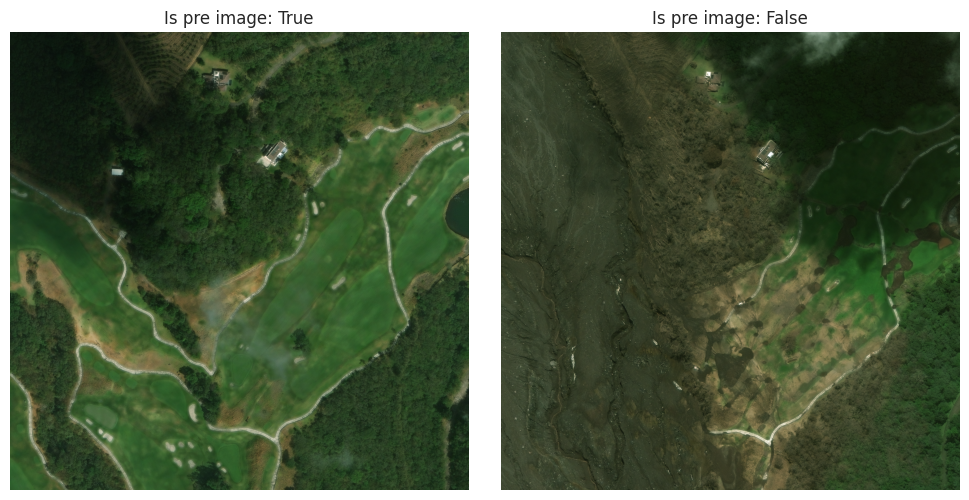

In [0]:
plt = plot_images_from_metadataframe(
    dataframe=sample_df,
    path_col="img_name",
    subplot_rows=1,
    subplot_cols=2,
    title_cols=["is_pre_image"],
    figsize=(10, 5),
)

plt.tight_layout()
plt.show()

### Summary Statistics

Total number of image pairs in data: 4665


<AxesSubplot: title={'center': 'Number of Unique Image Pairs per Dataset'}, ylabel='dataset'>

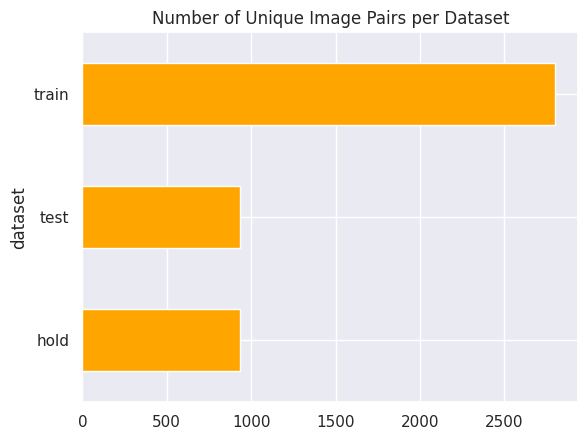

In [0]:
print("Total number of image pairs in data:", len(pair_df))

pair_df.groupby(["dataset"])["image_id"].count().plot(
    kind="barh",
    title="Number of Unique Image Pairs per Dataset",
    grid=True,
    color="orange",
)

<AxesSubplot: title={'center': 'Distribution of Pre-and-Post images in datasets'}, ylabel='dataset'>

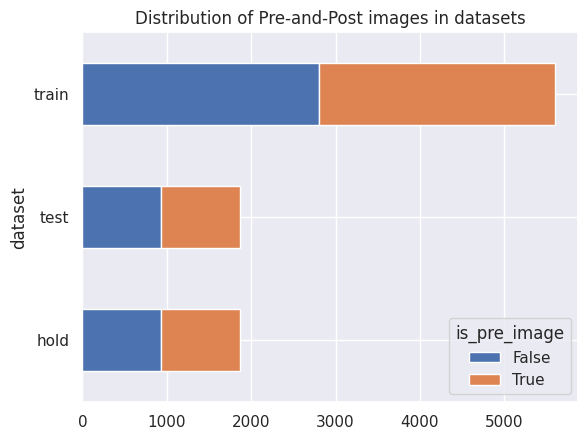

In [0]:
df_stacked: pd.DataFrame = img_df[["dataset", "is_pre_image"]].value_counts().unstack()
df_stacked.plot(
    kind="barh",
    stacked=True,
    grid=True,
    title="Distribution of Pre-and-Post images in datasets",
)

Total number of buildings in data: 272041


<AxesSubplot: title={'center': 'Number of Buildings per Dataset'}, ylabel='dataset'>

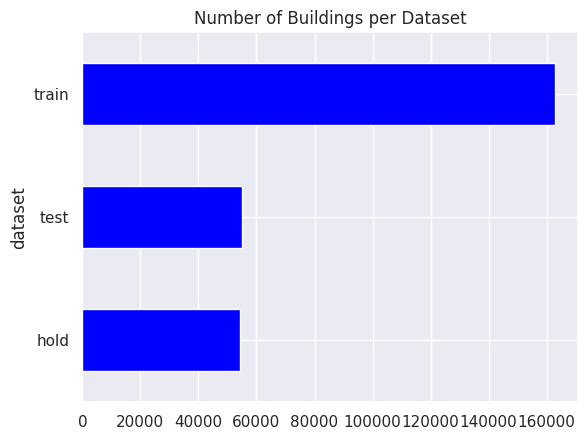

In [0]:
print("Total number of buildings in data:", df["building_id"].nunique())

df.groupby(["dataset"])["building_id"].nunique().plot(
    kind="barh",
    title="Number of Buildings per Dataset",
    grid=True,
    color="blue",
)

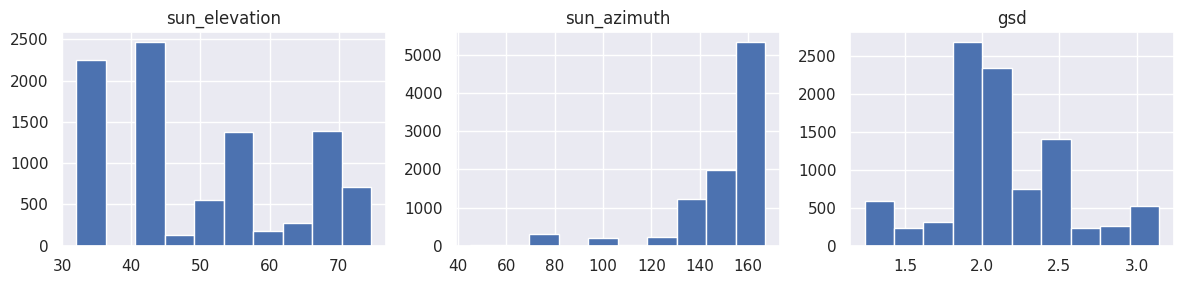

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4 * 3, 3))

img_df["sun_elevation"].hist(ax=axes[0])
axes[0].set_title("sun_elevation")

img_df["sun_azimuth"].hist(ax=axes[1])
axes[1].set_title("sun_azimuth")

img_df["gsd"].hist(ax=axes[2])
axes[2].set_title("gsd")

plt.tight_layout()
plt.show()

> Despite exploration, We may not want to include `azimuth`, `gsd`, `angles`, etc for feature engineering and model training as these would need to be furnished for all new images that we expect the model to predict outside of this dataset


#### Pick your Disaster
In the next few cells, we look at distributions of disasters, disaster classes against buildings. The more buildings we have with a decent class distribution, the better the MVP will be

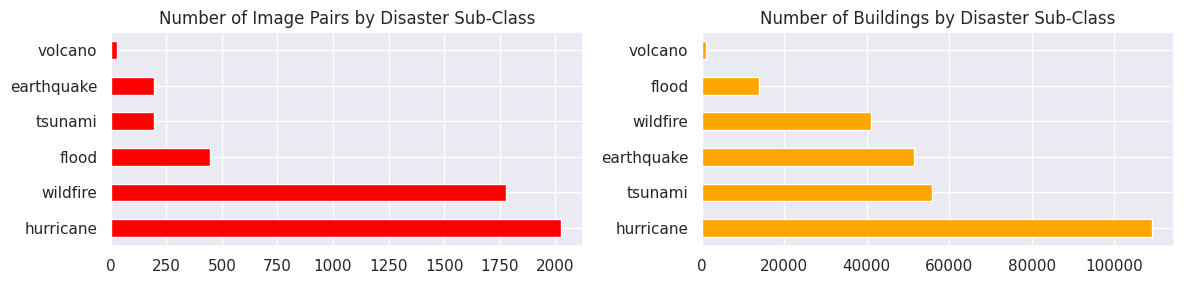

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4 * 3, 3))

pair_df["disaster_sub_type"].value_counts().plot(
    kind="barh",
    title="Number of Image Pairs by Disaster Sub-Class",
    color="red",
    ax=axes[0],
)


df[df.is_post_image].drop_duplicates(subset=["building_id"])[
    "disaster_sub_type"
].value_counts().plot(
    kind="barh",
    title="Number of Buildings by Disaster Sub-Class",
    color="orange",
    ax=axes[1],
)

plt.tight_layout()
plt.show()

<AxesSubplot: title={'center': 'Number of Buildings by Disaster Sub-Type'}, ylabel='disaster_sub_type'>

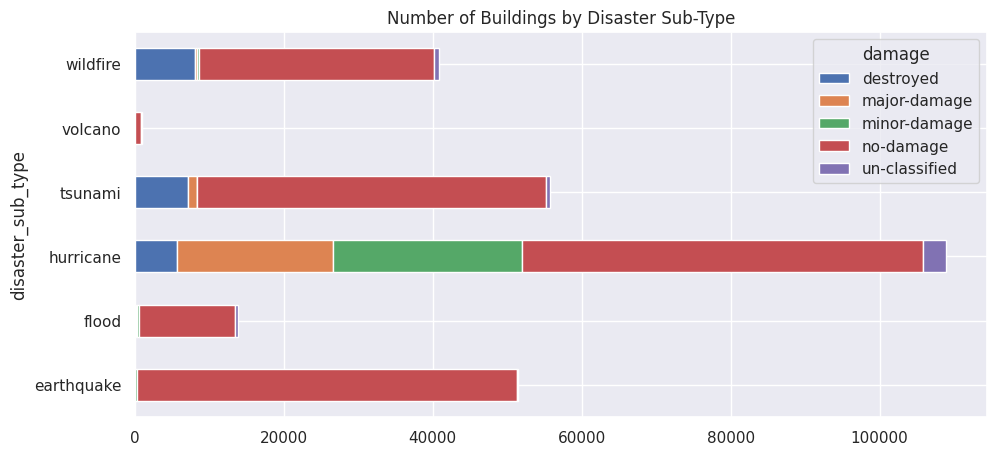

In [0]:
df[df.is_post_image].drop_duplicates(subset=["building_id"])[
    ["disaster_sub_type", "damage"]
].value_counts().unstack().plot(
    kind="barh",
    title="Number of Buildings by Disaster Sub-Type",
    stacked=True,
    grid=True,
    figsize=(11, 5),
)

In [0]:
b_i_per_disaster = pair_df.groupby(["disaster_sub_type"]).agg(
    building_count=("building_count", "sum"),
    image_count=("image_id", "count"),
)

b_i_per_disaster["buildings_per_image"] = (
    b_i_per_disaster["building_count"] / b_i_per_disaster["image_count"]
)

print(b_i_per_disaster.shape)
b_i_per_disaster.reset_index().sort_values(
    by=["buildings_per_image"], ascending=False
).round(0).style.highlight_max(
    subset=["building_count", "image_count", "buildings_per_image"]
)

(6, 3)


,disaster_sub_type,building_count,image_count,buildings_per_image
3,tsunami,55789,196,285.000000
0,earthquake,51473,193,267.000000
2,hurricane,108968,2023,54.000000
4,volcano,991,28,35.000000
1,flood,13896,445,31.000000
5,wildfire,40924,1780,23.000000


<AxesSubplot: title={'center': 'Number of Image Pairs by Disaster Sub Class - per Dataset'}, ylabel='dataset'>

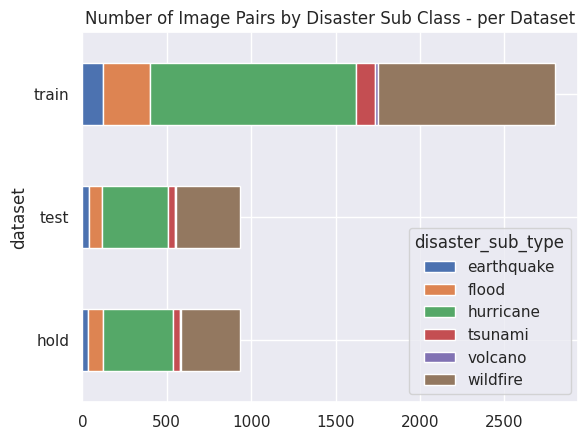

In [0]:
df.drop_duplicates(subset=["image_id"])[
    ["dataset", "disaster_sub_type"]
].value_counts().unstack().plot(
    kind="barh",
    title="Number of Image Pairs by Disaster Sub Class - per Dataset",
    grid=True,
    stacked=True,
)

Based on the summary statistics, training a model for **hurricanes** seems to be the top choice


### Save

In [0]:
img_df.to_parquet(f"s3://{S3_BUCKET}/datasets/xview2/processed/images.parquet")
pair_df.to_parquet(f"s3://{S3_BUCKET}/datasets/xview2/processed/image_pairs.parquet")
building_df.to_parquet(f"s3://{S3_BUCKET}/datasets/xview2/processed/buildings.parquet")